In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import numpy.linalg as npl
import pandas as pd
import viz
from tqdm import tqdm
from scipy import optimize
import scipy.stats
import torch
import models
import util
import style
from util import detach
import losses
import figs

PROCESSED_DIR = 'processed'
RESULTS_DIR = 'results'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

# loading

**load gt latents**

In [2]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [3]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N_A = len(attrs)

attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
attr_mat = (attr_mat - attr_mat.mean(axis=0)) / attr_mat.std(axis=0)
X = latents
Y = np.zeros(latents.shape) # pad Y with zeros, only first N rows have attributes
Y[:, :N_A] = attr_mat
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, Y, test_size=0.3, random_state=42)

**run by changing params in fit_inn.py**

In [70]:
# fname = '07_df_loss_tradeoff_nonlinear_INN_3lay'
# df.to_pickle(oj(PROCESSED_DIR, fname + '.pkl'))
# torch.save(m.state_dict(), oj(PROCESSED_DIR, fname + '.weights'))
# pkl.dump(p, open(oj(PROCESSED_DIR, fname + '_params.pkl'), 'wb'))

/home/ubuntu/face-disentanglement/src/figs.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.plot(df['mse'], df['indep_corr'], 'o-', label=v)
/home/ubuntu/face-disentanglement/src/figs.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.xlabel('Mean-squared error')
/home/ubuntu/face-disentanglement/src/figs.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuse

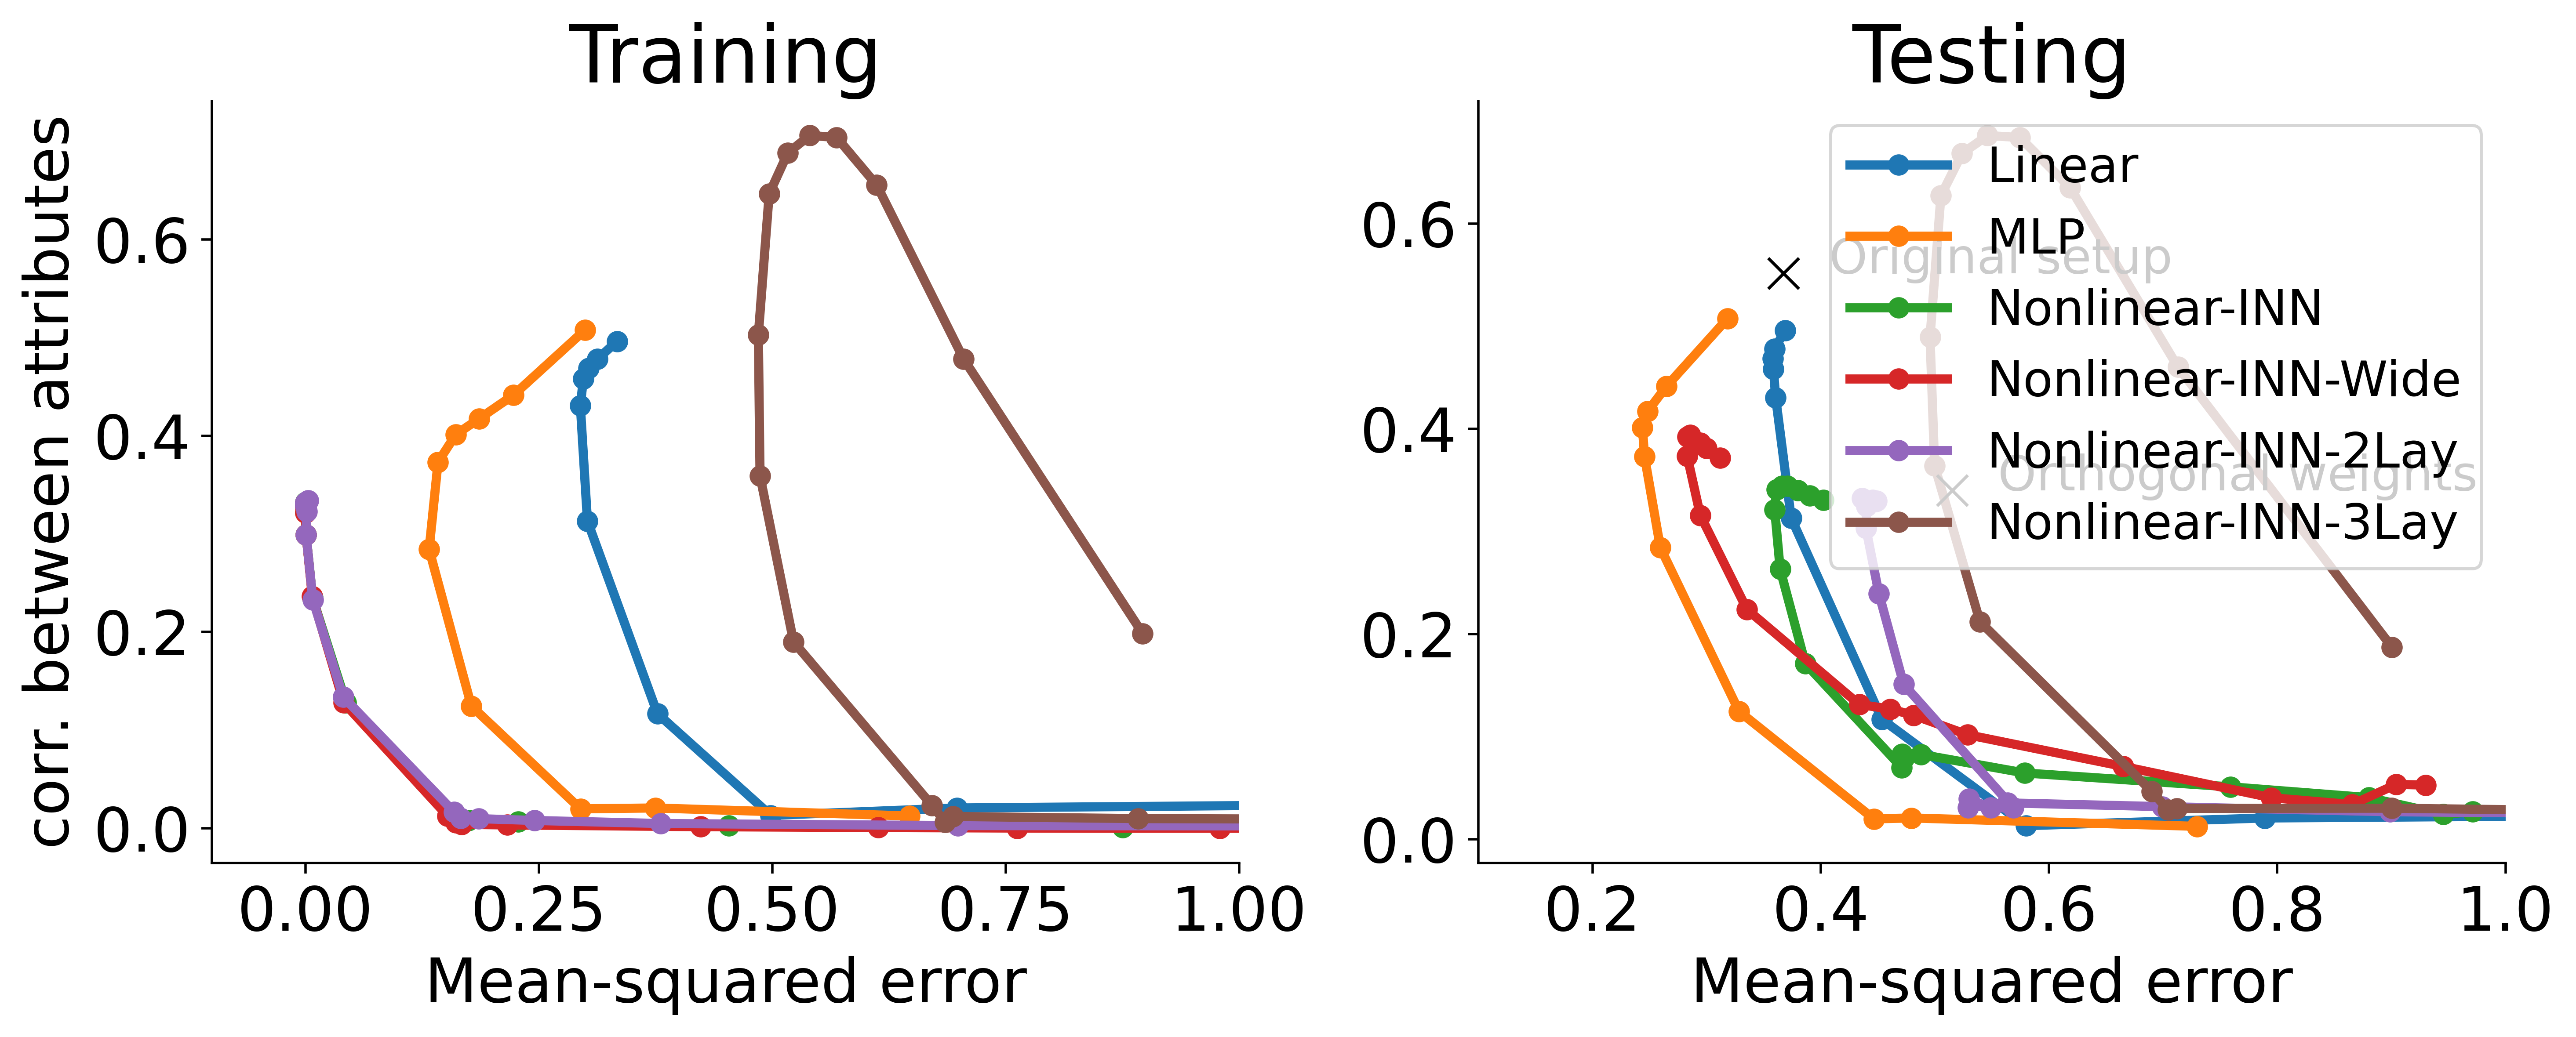

In [81]:
figs.plot_mse_vs_corrs()

**we are plotting mse but spearman corr probably makes more sense**

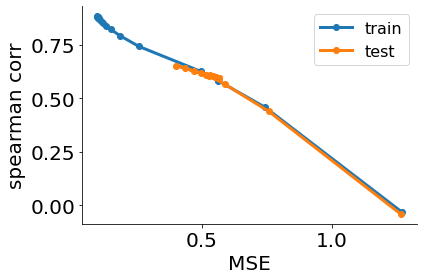

In [44]:
df = pd.read_pickle(oj(PROCESSED_DIR, '07_df_loss_tradeoff_nonlinear_INN.pkl'))
plt.plot(df['mse'], df['spearman'], 'o-', label='train')
plt.plot(df['mse_test'], df['spearman_test'], 'o-', label='test')
plt.xlabel('MSE')
plt.ylabel('spearman corr')
plt.legend()
plt.show()

In [128]:
preds_train = m(torch.Tensor(X_train)).detach().numpy()
preds_test = m(torch.Tensor(X_test)).detach().numpy()
print('shapes', preds_train.shape, preds_test.shape)

shapes (3500, 6) (1500, 6)


-0.06701056051352683
-0.0560786178909151
-0.007059932797258937
0.05037832516859507
0.03442539077078464
-0.03800710654858129


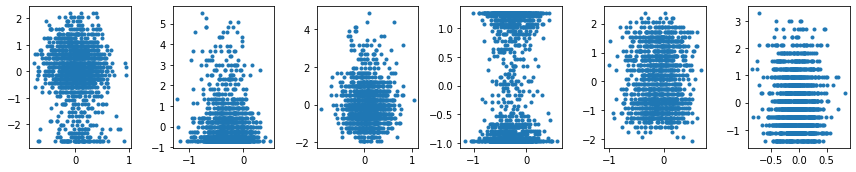

In [129]:
R, C = 1, 6
plt.figure(figsize=(12, 2.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds_test[:, i], y_test[:, i], '.')
    print(scipy.stats.spearmanr(preds_test[:, i], y_test[:, i]).correlation)

plt.tight_layout()
plt.show()

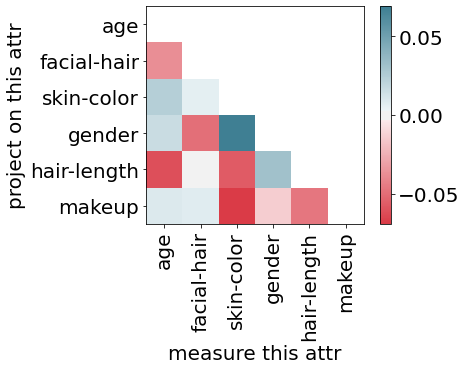

In [135]:
viz.corrplot(np.corrcoef(preds_test.transpose()))
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()